In [2]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

# data setting


In [3]:
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [4]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.preprocessing import RobustScaler

# Assuming X_train, X_test, y_train, y_test are your dataframes or arrays

# 將 X_train 和 X_test 轉換為張量並移動到指定設備上
x_in = torch.tensor(X_train.values, device=device, dtype=torch.float)
x_val = torch.tensor(X_test.values, device=device, dtype=torch.float)

# 對 y_train 和 y_test 進行 RobustScaler 縮放後轉換為張量
scaler = RobustScaler()
y_in_s = torch.tensor(scaler.fit_transform(y_train.values.reshape(-1, 1)), device=device, dtype=torch.float)
y_val_s = torch.tensor(scaler.transform(y_test.values.reshape(-1, 1)), device=device, dtype=torch.float)

# 將 y_train 和 y_test 直接轉換為張量
y_in = torch.tensor(y_train.values, device=device, dtype=torch.float)
y_val = torch.tensor(y_test.values, device=device, dtype=torch.float)

In [228]:
#Xavier initialization
def init_weights(m, k=1, gain=100):
    for i in m:
        if isinstance(i, nn.Linear):
            nn.init.xavier_normal_(i.weight, gain=gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()
#set DO and BN layer
def DO_BN(model,DO:bool,BN:bool):
    dropout_probs = [ 0.1,0.05,0.05]
    for name, module in model.named_modules():
        if isinstance(module, nn.Dropout):
            module.p =  dropout_probs.pop(0) if DO else 0
        if isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
            module.track_running_stats = BN

def forward(model,x,y,l2):
    y_pred = model(x)
    loss = nn.functional.mse_loss(y_pred,y).to(device)
    if l2:
        loss+=  l2_loss(model)
    return loss
    

'''def UA_module(model,l2,eta=1.2,epshon=0.7 ):
    forward(model,x_in,l2)'''



'def UA_module(model,l2,eta=1.2,epshon=0.7 ):\n    forward(model,x_in,l2)'

In [227]:
#trian process
def training(model,EB = True, LG = False,UA= False, DO = False, BN = False, l2 = True,
             regulization = True,initial_lr = 1e-3, stopping_lr = 6e-5, stopping_error = 0.05 if l2 else 0.15, stopping_epochs = 75):
    #set old model to output_model
    if regulization:
        output_model = model
    else:
        init_weights(model,0.1,1)
   
    DO_BN(model,DO,BN)

              # Disable tracking running statistics
    if UA and DO: print("Warning: Some error may occur for DO+ReduceLROnPlateau scheduler. Consider changing to CosineAnnealingLR scheduler.")



    #set Adam to be optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

    #set learning scheduler
    lr_scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10,verbose=True,
                                                              cooldown=10, min_lr=0, eps=1e-05)
    lr_scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=1.2, patience=20,verbose=True,
                                                               cooldown=0, min_lr=0, eps=1e-05)
     
    epochs = 0
    loss_in_list = []
    loss_out_list = []
    
    while True:
        #forward
        epochs += 1
        model.eval()# 切換到評估模式
        loss_out = forward(model,x_val,y_val_s,l2)

        model.train()  # 切換到訓練模式
        loss_in = forward(model,x_in,y_in_s,l2)
  
        #store loss values
        loss_in_list.append(loss_in.item())
        loss_out_list.append(loss_out.item())
        
        #check LG critiria
        if (loss_in < stopping_error) & LG:    
            print("LG stop")
            break      

        #backward
        optimizer.zero_grad()
        loss_in.backward()
        optimizer.step()
        #check UA critiria
        lr_scheduler1.step(loss_in)
        current_lr = optimizer.param_groups[0]['lr']
        if (current_lr<stopping_lr) & UA:
            print('UA stop')
            break
        lr_scheduler2.step(loss_in)

        #check EB critiria
        if (epochs >= stopping_epochs) & EB:
            print("EB stop")
            if ~UA & ~LG:
                if regulization and loss_in < stopping_error:
                    output_model = model
                    print('new model accept')
                else:
                    print("unacceptable model")
            break

        if regulization:
            output_model = model
            print('new model accept')   

        if UA:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 1.2
                
        print(f'Epoch {epochs}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')


    print(f'Training finished in {epochs} epochs.')
    
    if regulization:
        return loss_in_list,loss_out_list,stopping_error, output_model
    return loss_in_list, loss_out_list, stopping_error


In [85]:
#plot error
def draw_lr_step(loss_in_list,loss_out_list,stopping_error):
    # Assuming you have the epoch numbers as a list
    epoch_list = list(range(1, len(loss_in_list)+1))

    # Assuming you have the lists for loss_in and loss_out

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, loss_in_list, label='Loss In')
    plt.plot(epoch_list, loss_out_list, label='Loss Out')
    plt.axhline(y=stopping_error, color='gray', linestyle='--',
                linewidth=1.5, label='Stopping Value = '+str(stopping_error))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss of LG weight tuning')
    plt.legend()
    plt.ylim(0, 1)
    plt.scatter(epoch_list[-1], loss_out_list[-1], color='red', s=100, label='Last Point out')
    plt.text(epoch_list[-1], loss_out_list[-1]+0.03, f'  {loss_out_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.scatter(epoch_list[-1], loss_in_list[-1], color='red', s=100, label='Last Point in')
    plt.text(epoch_list[-1], loss_in_list[-1]+0.03, f'  {loss_in_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.grid(True)
    plt.show()


In [78]:
def draw_pred_reggsion(model,print_error = True):
    model.eval()
    y_pred_val_s = model(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
    y_pred_val = torch.Tensor(scaler.inverse_transform(torch.Tensor.cpu(y_pred_val_s).detach().numpy()))
    loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
    if print_error:
        print(torch.Tensor.cpu(loss1).tolist())
        print(torch.Tensor.cpu(loss2).tolist())
        

    y_pred_val_list = y_pred_val.tolist()
    y_val_list = y_val.tolist()
    # Perform linear regression
    slope, intercept = np.polyfit(np.array(y_pred_val_list).flatten(), np.array(y_val_list).flatten(), 1)

    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_val_list, y_val_list, 'o', label='Data points')
    plt.plot(y_pred_val_list, np.array(y_pred_val_list) * slope + intercept, '-', label='Regression line')
    plt.xlabel('Prediction')
    plt.ylabel('House Price')
    plt.title('Regression line between Prediction and House Price')
    plt.legend()
    plt.grid(True)
    plt.show()



## Best Model: 11 hidden  with RELU act

In [223]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(D_in, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, 50),
    nn.BatchNorm1d(50, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(50, 11),
    nn.BatchNorm1d(11, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(11, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

### 1. weight tuning EB  + regularizing_EB with l2  loss 

#### train with EB

In [226]:
EB = True
LG = False
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-1
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 20

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  

Epoch 1: Loss In 1.135325312614441, Loss Out 1.2352900505065918, Learning Rate 0.1
Epoch 2: Loss In 0.9282786250114441, Loss Out 1.1481941938400269, Learning Rate 0.12
Epoch 3: Loss In 0.9908918738365173, Loss Out 1.1771663427352905, Learning Rate 0.144
Epoch 4: Loss In 0.7809104323387146, Loss Out 0.9962930083274841, Learning Rate 0.17279999999999998
Epoch 5: Loss In 0.7678598165512085, Loss Out 0.9910145998001099, Learning Rate 0.20735999999999996
Epoch 6: Loss In 0.7844501733779907, Loss Out 1.0111032724380493, Learning Rate 0.24883199999999994
Epoch 7: Loss In 0.7454503178596497, Loss Out 0.9954564571380615, Learning Rate 0.29859839999999993
Epoch 8: Loss In 0.5653116703033447, Loss Out 0.8451583981513977, Learning Rate 0.3583180799999999
Epoch 9: Loss In 0.44298991560935974, Loss Out 0.5900896787643433, Learning Rate 0.4299816959999999
Epoch 10: Loss In 0.44952040910720825, Loss Out 0.642282247543335, Learning Rate 0.5159780351999999
Epoch 11: Loss In 0.5675579309463501, Loss Out 

In [107]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)



Epoch 1: Loss In 1.9295027256011963, Loss Out 2.3493192195892334, Learning Rate 0.001
Epoch 2: Loss In 1.478550672531128, Loss Out 1.9256863594055176, Learning Rate 0.001
Epoch 3: Loss In 1.1672534942626953, Loss Out 1.62724769115448, Learning Rate 0.001
Epoch 4: Loss In 1.0189638137817383, Loss Out 1.3809255361557007, Learning Rate 0.001
Epoch 5: Loss In 0.9075878858566284, Loss Out 1.1687835454940796, Learning Rate 0.001
Epoch 6: Loss In 0.8250803351402283, Loss Out 1.0281982421875, Learning Rate 0.001
Epoch 7: Loss In 0.7609534859657288, Loss Out 0.9624022841453552, Learning Rate 0.001
Epoch 8: Loss In 0.712587833404541, Loss Out 0.9439420700073242, Learning Rate 0.001
Epoch 9: Loss In 0.6830485463142395, Loss Out 0.9392090439796448, Learning Rate 0.001
Epoch 10: Loss In 0.6660388708114624, Loss Out 0.9361174702644348, Learning Rate 0.001
Epoch 11: Loss In 0.6440002918243408, Loss Out 0.9253593683242798, Learning Rate 0.001
Epoch 12: Loss In 0.6148546934127808, Loss Out 0.9084932804

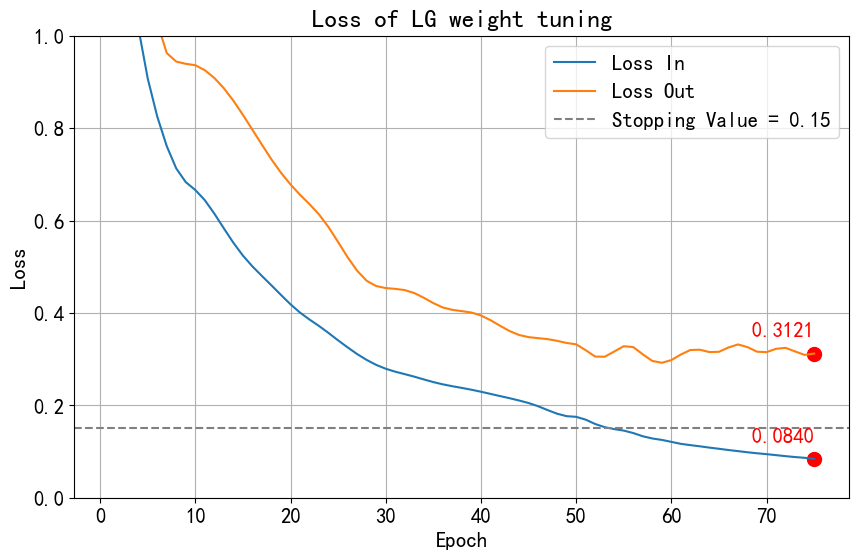

In [108]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.31595131754875183
12187933696.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


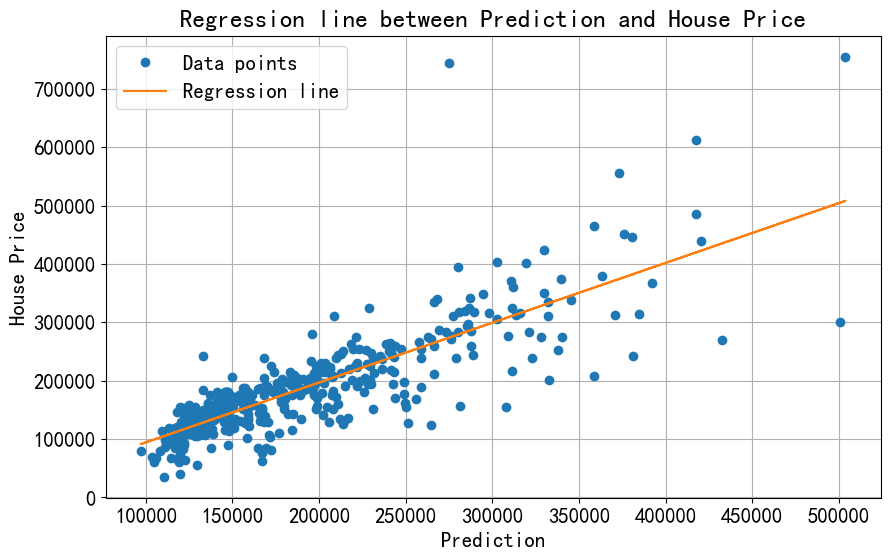

In [109]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB l2

In [116]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_regulization.append(model_11)

Epoch 1: Loss In 0.17286212742328644, Loss Out 0.39140552282333374, Learning Rate 0.001
Epoch 2: Loss In 0.47456470131874084, Loss Out 0.49667418003082275, Learning Rate 0.001
Epoch 3: Loss In 0.2604656219482422, Loss Out 0.4120521545410156, Learning Rate 0.001
Epoch 4: Loss In 0.267561674118042, Loss Out 0.4510737657546997, Learning Rate 0.001
Epoch 5: Loss In 0.2740524411201477, Loss Out 0.4937300682067871, Learning Rate 0.001
Epoch 6: Loss In 0.276716023683548, Loss Out 0.499795138835907, Learning Rate 0.001
Epoch 7: Loss In 0.2626263201236725, Loss Out 0.4763863682746887, Learning Rate 0.001
Epoch 8: Loss In 0.24484562873840332, Loss Out 0.44500237703323364, Learning Rate 0.001
Epoch 9: Loss In 0.23353970050811768, Loss Out 0.41915363073349, Learning Rate 0.001
Epoch 10: Loss In 0.22531330585479736, Loss Out 0.3987457752227783, Learning Rate 0.001
Epoch 11: Loss In 0.21733048558235168, Loss Out 0.38158759474754333, Learning Rate 0.001
Epoch 00012: reducing learning rate of group 0 

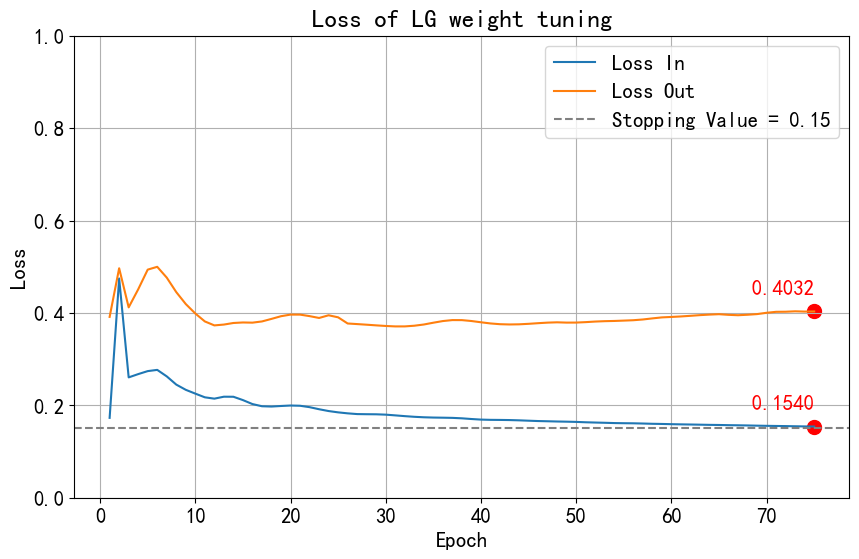

In [117]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.27561095356941223
12428423168.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


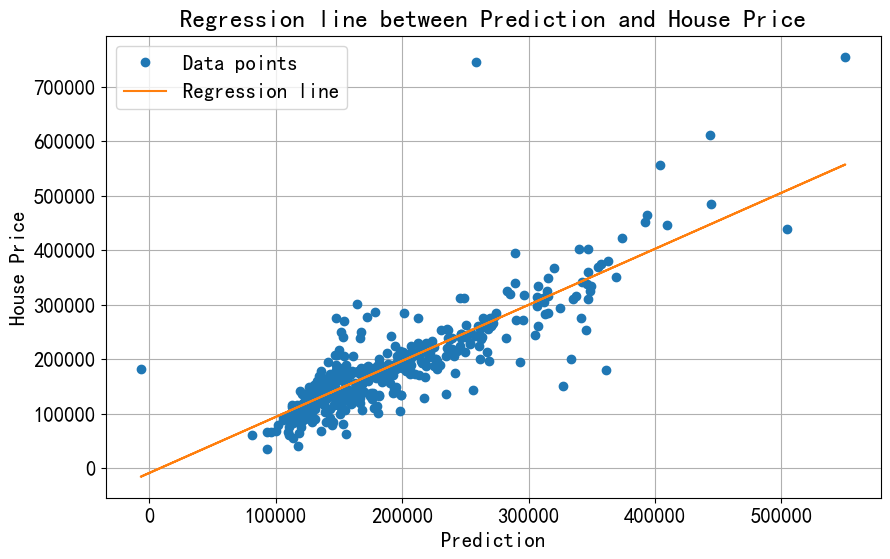

In [118]:
draw_pred_reggsion(model_11,print_error = True)

### 2. weight tuning LG UA  + regularizing_LG UA with l2  loss 

In [123]:
models_LGUA_accept = []
models_LGUA_regulization = []

#### train with EB

In [136]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.05 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_accept.append(model_11)



Epoch 1: Loss In 0.9619258642196655, Loss Out 1.1859105825424194, Learning Rate 0.001
Epoch 2: Loss In 0.9144266843795776, Loss Out 1.1573023796081543, Learning Rate 0.001
Epoch 3: Loss In 0.8807130455970764, Loss Out 1.1332157850265503, Learning Rate 0.001
Epoch 4: Loss In 0.850385844707489, Loss Out 1.1096044778823853, Learning Rate 0.001
Epoch 5: Loss In 0.8238192200660706, Loss Out 1.0876137018203735, Learning Rate 0.001
Epoch 6: Loss In 0.7982152700424194, Loss Out 1.0659533739089966, Learning Rate 0.001
Epoch 7: Loss In 0.7725502848625183, Loss Out 1.0450388193130493, Learning Rate 0.001
Epoch 8: Loss In 0.7457953095436096, Loss Out 1.0229651927947998, Learning Rate 0.001
Epoch 9: Loss In 0.7188624143600464, Loss Out 0.999182403087616, Learning Rate 0.001
Epoch 10: Loss In 0.6927546262741089, Loss Out 0.972791850566864, Learning Rate 0.001
Epoch 11: Loss In 0.6733756065368652, Loss Out 0.9437935948371887, Learning Rate 0.001
Epoch 12: Loss In 0.646980345249176, Loss Out 0.9150801

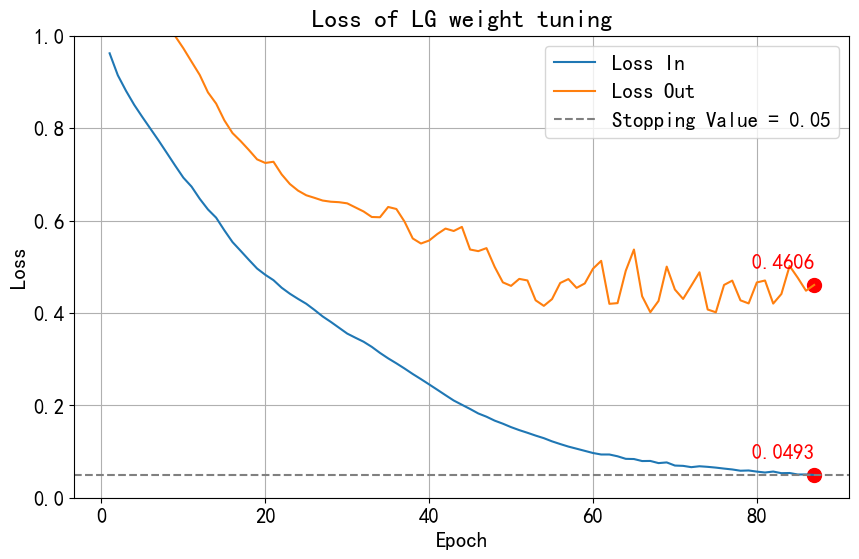

In [137]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.4979342520236969
11468347392.0


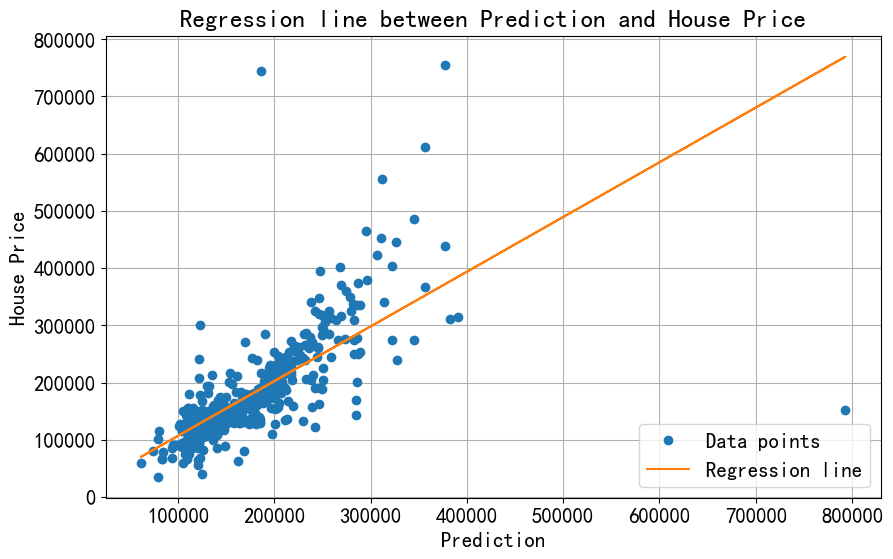

In [138]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with LG UA l2

In [161]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.25 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_regulization.append(model_11)

Epoch 1: Loss In 0.27999240159988403, Loss Out 0.6473259925842285, Learning Rate 0.001
Epoch 2: Loss In 0.9263520836830139, Loss Out 1.3729685544967651, Learning Rate 0.001
Epoch 3: Loss In 0.36552953720092773, Loss Out 0.748599648475647, Learning Rate 0.001
Epoch 4: Loss In 0.3797381818294525, Loss Out 0.6220116019248962, Learning Rate 0.001
Epoch 5: Loss In 0.42211461067199707, Loss Out 0.6573304533958435, Learning Rate 0.001
Epoch 6: Loss In 0.4348381757736206, Loss Out 0.6739435791969299, Learning Rate 0.001
Epoch 7: Loss In 0.42805683612823486, Loss Out 0.6789509654045105, Learning Rate 0.001
Epoch 8: Loss In 0.4156471788883209, Loss Out 0.6794613599777222, Learning Rate 0.001
Epoch 9: Loss In 0.4096735715866089, Loss Out 0.6759072542190552, Learning Rate 0.001
Epoch 10: Loss In 0.4009539783000946, Loss Out 0.6637143492698669, Learning Rate 0.001
Epoch 11: Loss In 0.38432085514068604, Loss Out 0.6417322158813477, Learning Rate 0.001
Epoch 00012: reducing learning rate of group 0 t

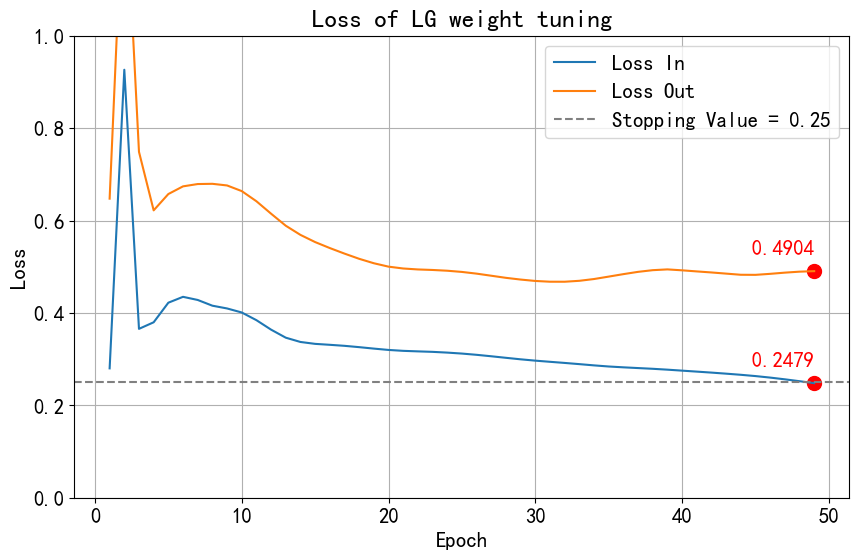

In [162]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.3439883887767792
10841287680.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


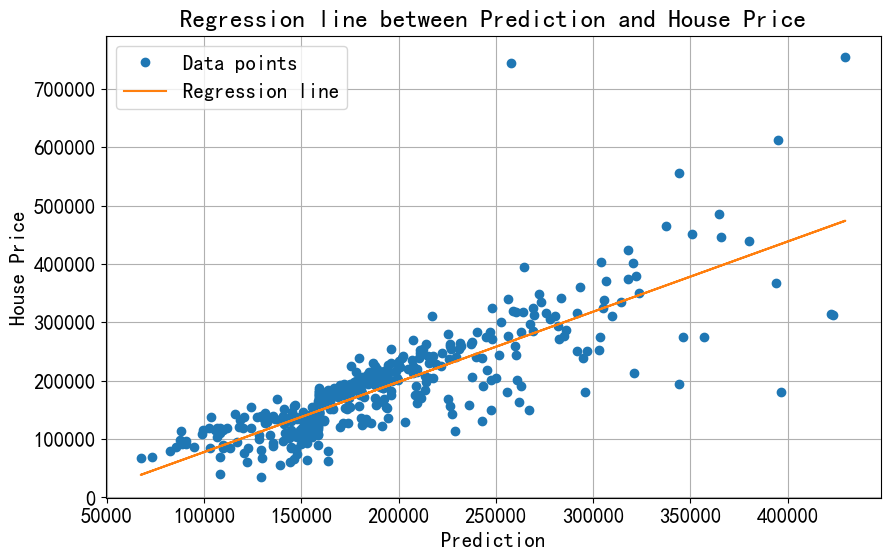

In [163]:
draw_pred_reggsion(model_11,print_error = True)

### 3. weight tuning EB LG UA  + regularizing EB LG UA  with l2  loss 

In [164]:
models_EBLGUA_accept = []
models_EBLGUA_regulization = []

#### train with EB LG UA 

In [202]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.2 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_accept.append(model_11)



Epoch 1: Loss In 0.9675272107124329, Loss Out 1.1803498268127441, Learning Rate 0.001
Epoch 2: Loss In 0.8485841155052185, Loss Out 1.0899795293807983, Learning Rate 0.001
Epoch 3: Loss In 0.7894133925437927, Loss Out 1.0567370653152466, Learning Rate 0.001
Epoch 4: Loss In 0.7483601570129395, Loss Out 1.013558030128479, Learning Rate 0.001
Epoch 5: Loss In 0.7235853672027588, Loss Out 0.9780945777893066, Learning Rate 0.001
Epoch 6: Loss In 0.7085696458816528, Loss Out 0.9638941884040833, Learning Rate 0.001
Epoch 7: Loss In 0.6918018460273743, Loss Out 0.953202486038208, Learning Rate 0.001
Epoch 8: Loss In 0.6688076257705688, Loss Out 0.9364874958992004, Learning Rate 0.001
Epoch 9: Loss In 0.6404830813407898, Loss Out 0.9112867116928101, Learning Rate 0.001
Epoch 10: Loss In 0.6097571849822998, Loss Out 0.8794330358505249, Learning Rate 0.001
Epoch 11: Loss In 0.5814236998558044, Loss Out 0.8412396907806396, Learning Rate 0.001
Epoch 12: Loss In 0.551746666431427, Loss Out 0.803434

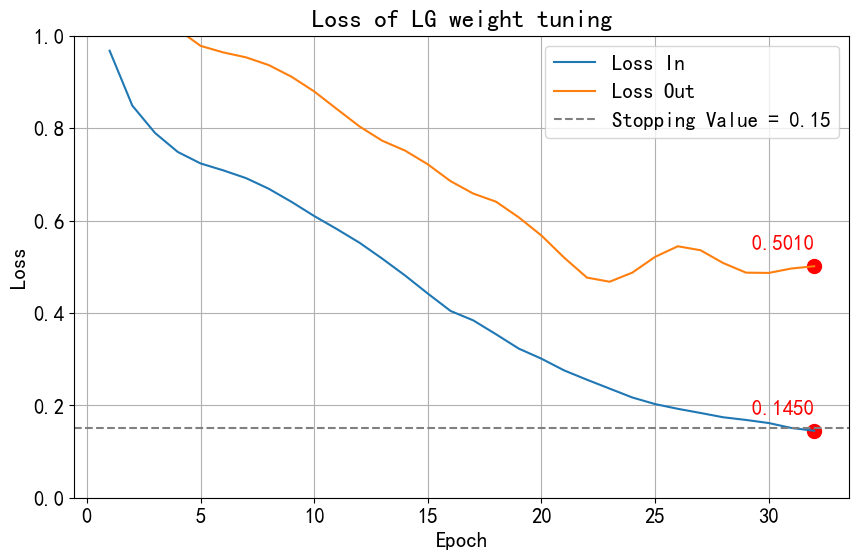

In [203]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.499349981546402
10572557312.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


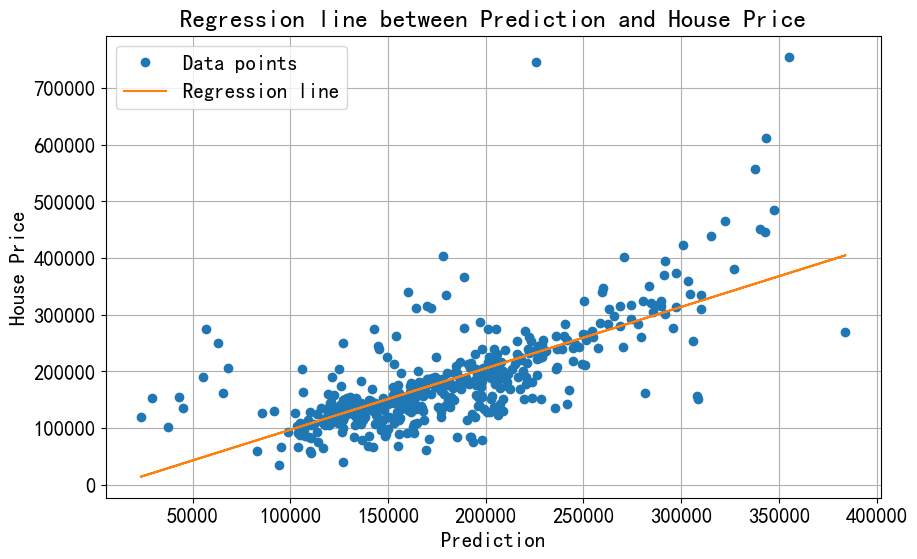

In [204]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB LG UA l2

In [205]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.3 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_regulization.append(model_11)

Epoch 1: Loss In 0.41335567831993103, Loss Out 0.7717833518981934, Learning Rate 0.001
Epoch 2: Loss In 0.47656023502349854, Loss Out 0.7114450931549072, Learning Rate 0.001
Epoch 3: Loss In 0.4485549032688141, Loss Out 0.6727380156517029, Learning Rate 0.001
Epoch 4: Loss In 0.4316427707672119, Loss Out 0.7973259091377258, Learning Rate 0.001
Epoch 5: Loss In 0.4367949962615967, Loss Out 0.8119949102401733, Learning Rate 0.001
Epoch 6: Loss In 0.4011860489845276, Loss Out 0.7868514060974121, Learning Rate 0.001
Epoch 7: Loss In 0.39598172903060913, Loss Out 0.7219997048377991, Learning Rate 0.001
Epoch 8: Loss In 0.39681893587112427, Loss Out 0.6827852725982666, Learning Rate 0.001
Epoch 9: Loss In 0.38140764832496643, Loss Out 0.6690711975097656, Learning Rate 0.001
Epoch 10: Loss In 0.37176400423049927, Loss Out 0.6924857497215271, Learning Rate 0.001
Epoch 11: Loss In 0.3734588325023651, Loss Out 0.7075042128562927, Learning Rate 0.001
Epoch 12: Loss In 0.3706558048725128, Loss Out

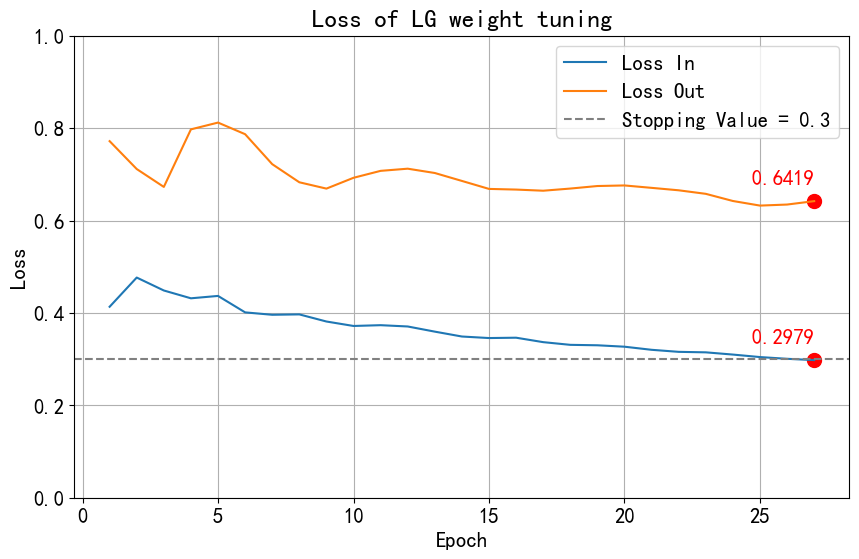

In [206]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.4210086166858673
10920335360.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


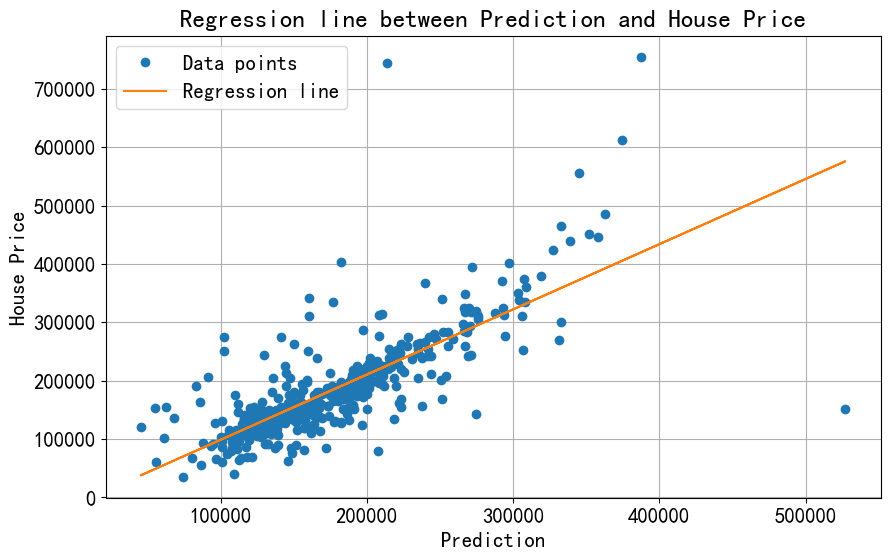

In [207]:
draw_pred_reggsion(model_11,print_error = True)

### 4. weight tuning EB   + regularizing DO

In [208]:
models_EBDO_accept = []
models_EBDO_regulization = []

#### train with EB DO

In [209]:
EB = True
LG = False
UA= False
DO = True
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.2 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_accept.append(model_11)



c:\Users\IanKu\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Loss In 1.403012990951538, Loss Out 1.6870497465133667, Learning Rate 0.000952211812496434
Epoch 2: Loss In 1.4344178438186646, Loss Out 1.6331267356872559, Learning Rate 0.0009500852126009458
Epoch 3: Loss In 1.3457918167114258, Loss Out 1.551131010055542, Learning Rate 0.0009559732586296795
Epoch 4: Loss In 1.3698809146881104, Loss Out 1.4426112174987793, Learning Rate 0.0009544076430023297
Epoch 5: Loss In 1.1567871570587158, Loss Out 1.3441998958587646, Learning Rate 0.0009673441014394013
Epoch 6: Loss In 1.0961759090423584, Loss Out 1.2618277072906494, Learning Rate 0.0009706435196713399
Epoch 7: Loss In 1.0548896789550781, Loss Out 1.1915056705474854, Learning Rate 0.0009727933291513219
Epoch 8: Loss In 0.9949259161949158, Loss Out 1.133053183555603, Learning Rate 0.0009757739493669646
Epoch 9: Loss In 1.0759861469268799, Loss Out 1.0856101512908936, Learning Rate 0.0009717047329021898
Epoch 10: Loss In 0.9218504428863525, Loss Out 1.0514692068099976, Learning Rate 0.000

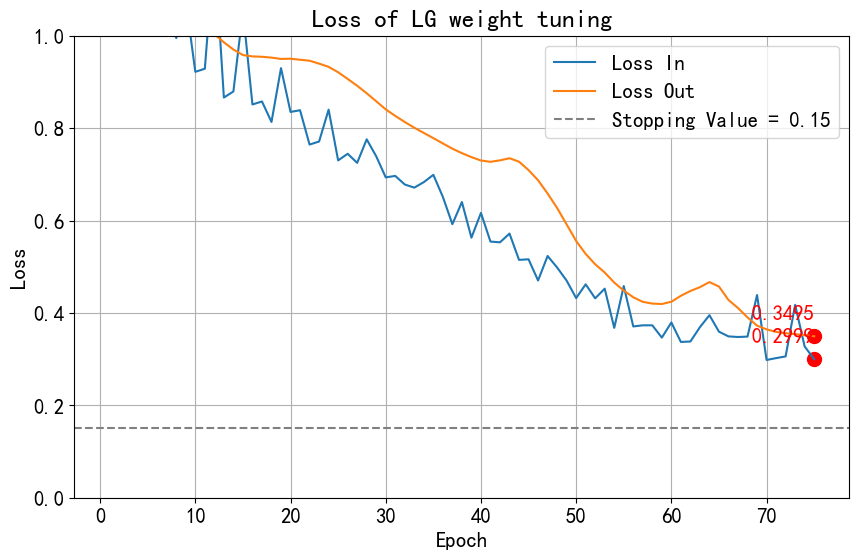

In [210]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.34706711769104004
10738696192.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


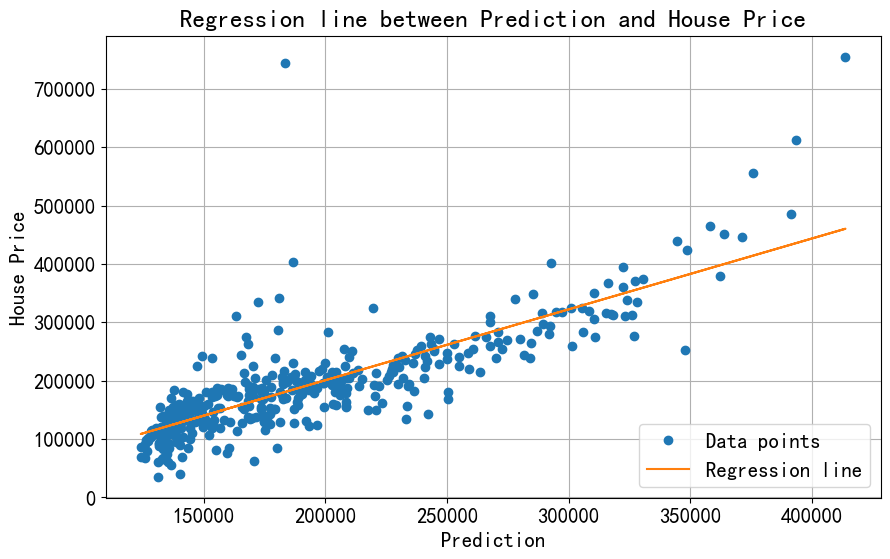

In [211]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB LG UA l2

In [212]:
EB = True
LG = False
UA= False
DO = True
BN = False
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.3 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_regulization.append(model_11)

c:\Users\IanKu\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Loss In 0.2802908420562744, Loss Out 0.34706711769104004, Learning Rate 0.0009980627888354428
Epoch 2: Loss In 0.27033868432044983, Loss Out 0.35740095376968384, Learning Rate 0.000998197832616004
Epoch 3: Loss In 0.2820192277431488, Loss Out 0.38792186975479126, Learning Rate 0.0009980388395022981
Epoch 4: Loss In 0.27062347531318665, Loss Out 0.3806401789188385, Learning Rate 0.0009981940360163188
Epoch 5: Loss In 0.29226553440093994, Loss Out 0.3637790381908417, Learning Rate 0.0009978938472066802
Epoch 6: Loss In 0.26130127906799316, Loss Out 0.3495638072490692, Learning Rate 0.0009983162447499874
Epoch 7: Loss In 0.25845569372177124, Loss Out 0.33463966846466064, Learning Rate 0.0009983526973345192
Epoch 8: Loss In 0.2327243685722351, Loss Out 0.32691097259521484, Learning Rate 0.0009986642351227284
Epoch 9: Loss In 0.2250739485025406, Loss Out 0.32489490509033203, Learning Rate 0.0009987505774815655
Epoch 10: Loss In 0.25541529059410095, Loss Out 0.3213152289390564, Lear

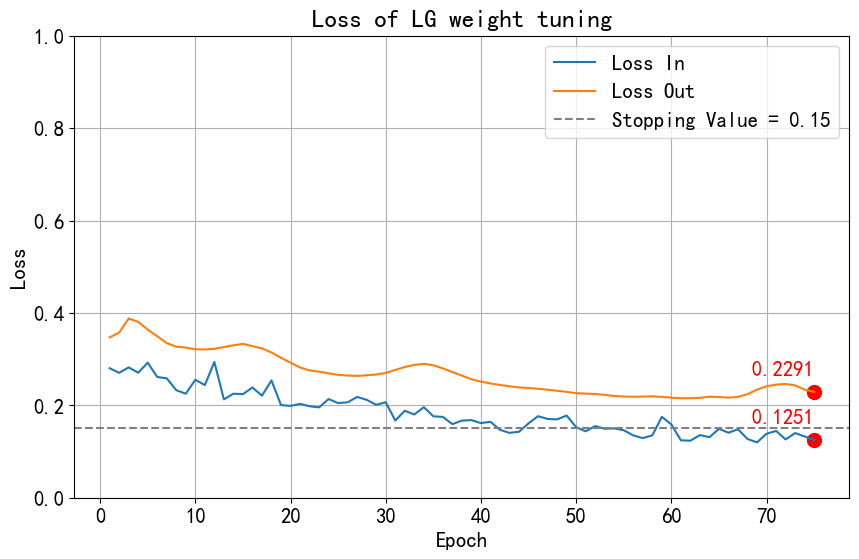

In [213]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.4210086166858673
10920335360.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_1544\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


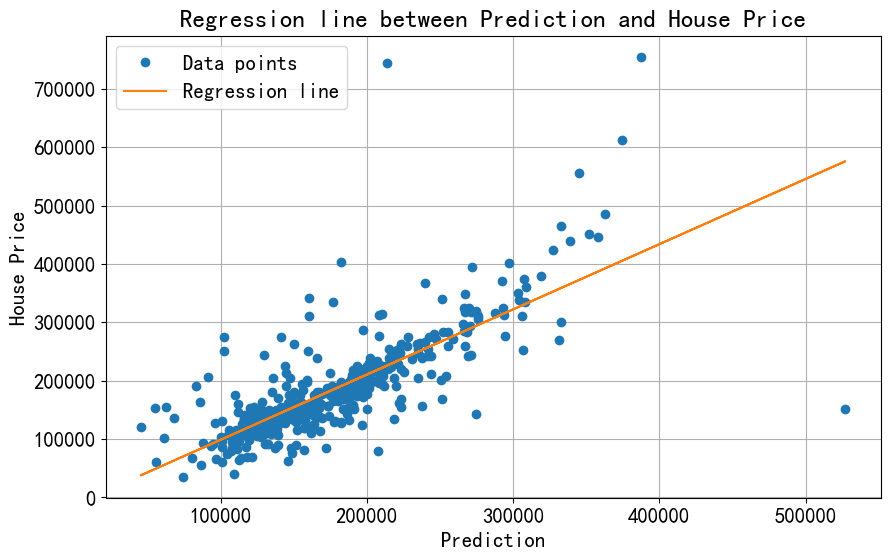

In [ ]:
draw_pred_reggsion(model_11,print_error = True)

## Conclusion
#### 這次加加上了顯卡支援跑到了大約50000 epochs 左右，效果也稍微有提升，我發現torch 套件的 torch.optim.lr_scheduler 的 ReduceLROnPlateau 就是在做UA的部分

## hidden nodes:
#### 6 layer 214*150*100*50*20*11*1 沒做drop 
## initial weight:
#### Xavier 優化了code 也丟到GPU上
## Activation:
#### 主要用RELU, Activation function 的種類影響蠻大的
## Loss:
#### MSE + l2 regulization 跑得真的比較久但是新電腦有顯卡支援
## Optmizer epoch
#### Adam 
## learning_rate
#### 起始值設10^-3, UA停止值設 10^-8, 用ReduceLROnPlateau做UA learn rate decay, loss > 0.1時 lr大概在10^-6 上下，到10^-7左右時跑的超慢
## Ensembles
#### 下次一定做
## Batch Normalization
#### 下次一定做
